In [1]:
import os
import pandas as pd
import numpy as np
import json

# Data Processing

In [2]:
DATA_ROOT = "../data"
PRODUCT_PATH = os.path.join(DATA_ROOT, 'product_detail/json')
BS_PATH = os.path.join(DATA_ROOT, 'bestseller/bsData')

print(f'Product Detail Dir: {os.listdir(PRODUCT_PATH)[0:5]}')
print(f'Best Seller Dir: {os.listdir(BS_PATH)[0:5]}')

Product Detail Dir: ['B071FXZBMV.json', 'B096WLN8XJ.json', 'B09B2QR6LR.json', 'B09T3P7MJ9.json', 'B003I7HS5M.json']
Best Seller Dir: ['industrial_2.json', 'magazines_2.json', 'musical_2.json', 'sports_2.json', 'electronics_1.json']


## Product Detail Data

In [3]:
product_rows = []
product_overview = {}
for filename in os.listdir(PRODUCT_PATH):
    with open(f'{PRODUCT_PATH}/{filename}', 'r') as f:
        product = json.load(f)
        id_, overview = product['id'], product['overview']
        product_overview[id_] = overview
        # remove overview from the product dict
        product.pop('overview')
        # title is the same as id
        product.pop('title')
        # store product in a pandas dataframe
        product_rows.append(product)        


In [4]:
df_prod = pd.DataFrame(product_rows)
print('column data type:\n', df_prod.dtypes)

print('number of rows: ', len(df_prod))
print('number of unique id: ', len(df_prod['id'].unique()))
# Primary Key
assert len(df_prod) == len(df_prod['id'].unique())

df_prod.head()

column data type:
 id               object
price           float64
discount        float64
country          object
quantity          int64
missOverview       bool
missDiscount       bool
missCountry        bool
missQuantity       bool
missPrice          bool
dtype: object
number of rows:  786
number of unique id:  786


,id,price,discount,country,quantity,missOverview,missDiscount,missCountry,missQuantity,missPrice
0,B071FXZBMV,8.99,0.0,US,30,False,True,False,False,False
1,B096WLN8XJ,44.00,0.0,US,2,True,True,False,False,False
2,B09B2QR6LR,17.90,0.0,US,7,True,True,False,False,False
3,B09T3P7MJ9,16.25,0.0,US,13,False,True,False,False,False
4,B003I7HS5M,0.00,0.0,US,0,True,True,False,False,True


In [5]:
product_overview['B071FXZBMV']

{'_Color_': 'Black',
 '_Brand_': 'OHill',
 '_Item_Weight_': '0.15 Pounds',
 '_Binding_': 'Unknown Binding'}

## Best Seller Data

In [6]:
bs_rows = []
bs_overview = {}
for filename in os.listdir(BS_PATH):
    with open(f'{BS_PATH}/{filename}', 'r') as f:
        bs = json.load(f)
        # remove child_categories, next and url from the list
        bs.pop('child_categories')
        bs.pop('next')
        bs.pop('url')
        # now only category and product_listings left
        _category, _product_listings = bs['category'], bs['product_listings']
        for product_listing in _product_listings:
            _id, _rank, _name, _ratings_count, _rating = product_listing['asin'], product_listing['rank'], product_listing['name'], product_listing[
                'ratings_count'], product_listing['rating']
            if _id == None:
                continue
            temp = [_id, _rank, _name, _ratings_count, _rating, _category]
            bs_rows.append(temp)


In [7]:
df_bs = pd.DataFrame(bs_rows)
df_bs.columns = ['id', 'rank', 'name', 'ratings_count', 'rating', 'category']

# convert data type
df_bs['rating'] = df_bs['rating'].astype(float)
df_bs['ratings_count'] = df_bs['ratings_count'].astype(float)
print('column data type:\n', df_bs.dtypes)

# sort data 
df_bs = df_bs.sort_values(by=['category', 'rank'])
df_bs.head()

column data type:
 id                object
rank               int64
name              object
ratings_count    float64
rating           float64
category          object
dtype: object


,id,rank,name,ratings_count,rating,category
397,B079V67BFW,1,"Pampers Choose Your Count, Sensitive Water Bas...",42199.0,4.8,Baby
398,B07SVHLGV8,2,"Diapers Newborn/Size 0 (< 10 lb), 140 Count - ...",54499.0,4.8,Baby
399,B07MB5RY9N,3,"Baby Wipes, Huggies Natural Care Sensitive Bab...",70559.0,4.8,Baby
400,B0779Z53SD,4,"WaterWipes Original Baby Wipes, 99.9% Water, U...",1408.0,4.8,Baby
401,B08QRKY3NJ,5,"Baby Wipes, Unscented, Huggies Simply Clean Fr...",18881.0,4.8,Baby


In [8]:
print('number of rows: ', len(df_bs))
print('number of unique id: ', len(df_bs['id'].unique()))
# print duplicate data
mask = df_bs['id'].duplicated(keep=False)
print('Duplicated Rows:')
df_bs[mask].sort_values('id')
# Drop duplicate
df_bs = df_bs.drop_duplicates(subset=['id'], keep='first')
print('number of rows: ', len(df_bs))
print('number of unique id: ', len(df_bs['id'].unique()))
assert len(df_bs['id']) == len(df_bs['id'].unique())

number of rows:  994
number of unique id:  986
Duplicated Rows:
number of rows:  986
number of unique id:  986


## Join two tables & Define top seller

In [9]:
# join product and bestseller table
df = pd.merge(df_prod, df_bs, on="id")
df.head()

,id,price,discount,country,quantity,missOverview,missDiscount,missCountry,missQuantity,missPrice,rank,name,ratings_count,rating,category
0,B071FXZBMV,8.99,0.0,US,30,False,True,False,False,False,31,"OHill Cable Clips,16 Pack Black Adhesive Cord ...",45032.0,4.5,Electronics
1,B096WLN8XJ,44.00,0.0,US,2,True,True,False,False,False,38,2021 Topps Series 2 Baseball Blaster Box,203.0,4.7,Sports Collectibles
2,B09B2QR6LR,17.90,0.0,US,7,True,True,False,False,False,81,2021 Panini Prizm Draft Picks Football CELLO p...,21.0,4.1,Sports Collectibles
3,B09T3P7MJ9,16.25,0.0,US,13,False,True,False,False,False,7,"Kitchens Slow Cooker Liners, Regular (Fits 3-8...",NaN,NaN,Kitchen & Dining
4,B003I7HS5M,0.00,0.0,US,0,True,True,False,False,True,40,Ranger Rick Jr.,1595.0,4.7,Magazine Subscriptions


In [10]:
# remove NAN
df = df.dropna()
df.head()

,id,price,discount,country,quantity,missOverview,missDiscount,missCountry,missQuantity,missPrice,rank,name,ratings_count,rating,category
0,B071FXZBMV,8.99,0.00,US,30,False,True,False,False,False,31,"OHill Cable Clips,16 Pack Black Adhesive Cord ...",45032.0,4.5,Electronics
1,B096WLN8XJ,44.00,0.00,US,2,True,True,False,False,False,38,2021 Topps Series 2 Baseball Blaster Box,203.0,4.7,Sports Collectibles
2,B09B2QR6LR,17.90,0.00,US,7,True,True,False,False,False,81,2021 Panini Prizm Draft Picks Football CELLO p...,21.0,4.1,Sports Collectibles
4,B003I7HS5M,0.00,0.00,US,0,True,True,False,False,True,40,Ranger Rick Jr.,1595.0,4.7,Magazine Subscriptions
5,B005HNZ5T6,11.60,13.36,US,90,False,False,False,False,False,69,"uni-ball 207 Retractable Gel Pens, Bold Point ...",28045.0,4.7,Office Products


In [11]:
# define top seller: rank < 50
df['label'] = 0
top_idx = df['rank'] < 50
df[top_idx] = df[top_idx].assign(label=1)
df.head()

,id,price,discount,country,quantity,missOverview,missDiscount,missCountry,missQuantity,missPrice,rank,name,ratings_count,rating,category,label
0,B071FXZBMV,8.99,0.00,US,30,False,True,False,False,False,31,"OHill Cable Clips,16 Pack Black Adhesive Cord ...",45032.0,4.5,Electronics,1
1,B096WLN8XJ,44.00,0.00,US,2,True,True,False,False,False,38,2021 Topps Series 2 Baseball Blaster Box,203.0,4.7,Sports Collectibles,1
2,B09B2QR6LR,17.90,0.00,US,7,True,True,False,False,False,81,2021 Panini Prizm Draft Picks Football CELLO p...,21.0,4.1,Sports Collectibles,0
4,B003I7HS5M,0.00,0.00,US,0,True,True,False,False,True,40,Ranger Rick Jr.,1595.0,4.7,Magazine Subscriptions,1
5,B005HNZ5T6,11.60,13.36,US,90,False,False,False,False,False,69,"uni-ball 207 Retractable Gel Pens, Bold Point ...",28045.0,4.7,Office Products,0


# Hypothesis Testing
The group must formulate a minimum of three distinct research hypotheses, and test them using a statistical testing method.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [13]:
# all the categories
print(df['category'].unique())

['Electronics' 'Sports Collectibles' 'Magazine Subscriptions'
 'Office Products' 'Camera & Photo Products' 'Industrial & Scientific'
 'Kitchen & Dining' 'Baby']


## Hypothesis Testing 1

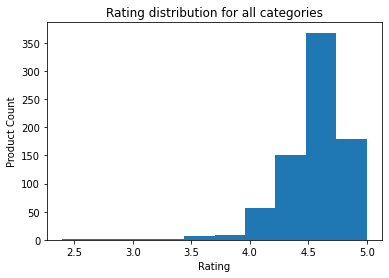

In [44]:
# Overall
plt.hist(df['rating'], bins=10)
plt.title("Rating distribution for all categories")
plt.xlabel("Rating")
plt.ylabel("Product Count")
plt.show()

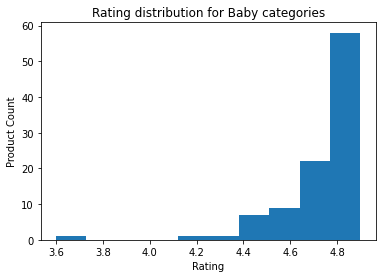

In [45]:
# 'Baby' distribution
plt.hist(df[df['category']=='Baby']['rating'], bins=10)
plt.title("Rating distribution for Baby categories")
plt.xlabel("Rating")
plt.ylabel("Product Count")
plt.show()

Now we have the hypothesis

$H_0$: The ratings of category 'Baby' shows no difference from the ratings of the others.

$H_1$: The ratings of category 'Baby' shows a significant difference from the ratings of the others.

In [27]:
sample_baby = df[df['category']=='Baby']['rating']
baby_mean = np.mean(sample_baby)
rating_population = df['rating']
population_mean = np.mean(rating_population)
n = np.shape(sample_baby)[0]
variance = np.var(rating_population)
z = (baby_mean - population_mean) / (np.sqrt(variance/(n)))
print('The test stats is', z)

The test stats is 5.98191204258953


### Analysis 1
We can reject the null hypothesis since $\alpha = 0.05$, $1 - \alpha/2 = 0.975$ and the test stats is 5.98191204258953, which is positive and indicates that the rejection region is on the right, so we have the corresponding value in z-table as 1.960, which is less than 5.98191204258953.

Therefore, we can say the products which are in the 'Baby' category are of higher quality, these sellers tend to have more quality control in this area compare with the overall rating distribution of all the categories.

## Hypothesis Testing 2

In [36]:
# Vectorize function
length_checker = np.vectorize(len)

category_electronics = df[df['category']=='Electronics']
elec_top50_name = category_electronics[category_electronics['label']==1]['name']
elec_51plus_name = category_electronics[category_electronics['label']==0]['name']

# get length of each name
top_len = length_checker(elec_top50_name)
last_len = length_checker(elec_51plus_name)

# print(top_len)
# print(last_len)


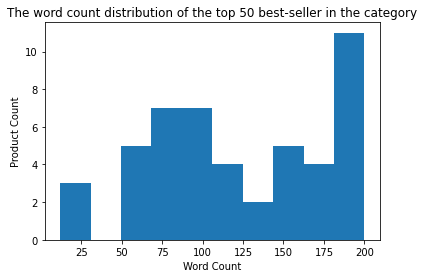

In [39]:
# Top 50
plt.hist(top_len, bins=10)
plt.title("The word count distribution of the top 50 best-seller in the category")
plt.xlabel("Word Count")
plt.ylabel("Product Count")
# plt.hist(last_len, bins=10)
plt.show()

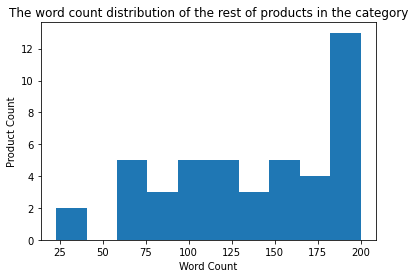

In [47]:
# 51+
plt.hist(last_len, bins=10)
plt.title("The word count distribution of the rest of products in the category")
plt.xlabel("Word Count")
plt.ylabel("Product Count")
# plt.hist(last_len, bins=10)
plt.show()

Now we have the hypothesis

$H_0$: The length of the product title of the electronic category is irrelavant to being best seller.

$H_1$: The length of the product title of the electronic category is relavant to being best seller.

In [46]:
n_top = np.shape(top_len)[0]
n_last = np.shape(last_len)[0]
t = (np.mean(top_len) - np.mean(last_len)) / (np.sqrt((np.var(top_len))/n_top + (np.var(last_len))/n_last))
t

-1.4526947546293916

In [52]:
v_1 = np.var(top_len)
v_2 = np.var(last_len)
n_1 = np.shape(top_len)[0]
n_2 = np.shape(last_len)[0]

nr = ((v_1/n_1) + (v_2/n_2))**2
dr = (((v_1/n_1)**2)/(n_1 - 1)) + (((v_2/n_2)**2)/(n_2 - 1))

print("degrees_of_freedom =", nr / dr)

degrees_of_freedom = 90.999513442532


In [53]:
print(len(top_len)+len(last_len))

93


### Analysis 2
We cannot reject the null hypothesis since degree of freedom is 90.999513442532 and the test stats is -1.4526947546293916, which is negative and indicates that the rejection region is on the left, so we have the corresponding value in t-table as -1.987, which is less than -1.4526947546293916.

Therefore, we can say that of 95% chance the length of the name is irrelavant to being the best seller. In other words, how long do the sellers descript the products won't have impact on being best sellers.

## Hypothesis Testing 3

In [148]:
top50_name = df[df['label']==1].iloc[:, [14,12]].groupby('category').sum()
overall_name = df.iloc[:, [14,12]].groupby('category').sum()

# print(top50_name[0, :])
# print(top50_name['category'])
# top50_name.groupby('category').sum()


In [149]:
top50_name

,ratings_count
category,
Baby,1468092.0
Camera & Photo Products,397632.0
Electronics,4368936.0
Industrial & Scientific,1173969.0
Kitchen & Dining,1954847.0
Magazine Subscriptions,354759.0
Office Products,1897105.0
Sports Collectibles,14338.0


In [151]:
overall_name

,ratings_count
category,
Baby,2412915.0
Camera & Photo Products,727130.0
Electronics,6005474.0
Industrial & Scientific,1994542.0
Kitchen & Dining,3269180.0
Magazine Subscriptions,504523.0
Office Products,3005608.0
Sports Collectibles,19801.0


In [152]:
top50_name / overall_name

,ratings_count
category,
Baby,0.608431
Camera & Photo Products,0.546851
Electronics,0.727492
Industrial & Scientific,0.588591
Kitchen & Dining,0.597962
Magazine Subscriptions,0.703157
Office Products,0.631188
Sports Collectibles,0.724105


From the tables above we can see that the ratios in different categories vary. Therefore, we can have the hypothesis below.

$H_0$: The number of rating count and being a best seller are independent.

$H_1$: There is an association between the number of rating count and being a best seller.

In [128]:
obs = top50_name
pop_ratios = overall_name/len(overall_name)
# expected counts
exp = pop_ratios * len(top50_name)   
chi_squared_stat = (((obs-exp)**2)/exp).sum()
print(chi_squared_stat)

ratings_count    2.286039e+06
dtype: float64


### Analysis 3
We can reject the null hypothesis since according to the [chi-square table]( https://people.richland.edu/james/lecture/m170/tbl-chi.htmlsince), $\alpha = 0.05$ and the number of category is 8, which means that $df = 7$, we have the critical value is 14.067, and this value is less than the chi_square stats.

Actually even when $\alpha = 0.005$, the critical value is 20.278, which is still less than the stats, so we can say that it is of 99.5% chance that there is an association between the number of rating count and being a best seller.